In [2]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import time

In [3]:
# Primer paso: Jalar el dataset procesado por el archivo de file.

caravan = pd.read_csv("ticdata2000_wh.txt", sep = "|")
caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


In [5]:
caravan

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,2,0,0,0,1,0,0,0,0,0
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,0,1,0,0,0,0,0
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


In [6]:
missings_prop = caravan.apply(lambda x: round(x.isnull().sum()/caravan.shape[0]*100, 2))
missings_numeric_caravan = pd.DataFrame({'proporcion_de_valores_faltantes': missings_prop})
missings_numeric_caravan

,proporcion_de_valores_faltantes
MOSTYPE,0.0
MAANTHUI,0.0
MGEMOMV,0.0
MGEMLEEF,0.0
MOSHOOFD,0.0
...,...
AZEILPL,0.0
APLEZIER,0.0
AFIETS,0.0
AINBOED,0.0


In [8]:
# No se encuntran NA's en el dataset.

missings_numeric_caravan[missings_numeric_caravan.proporcion_de_valores_faltantes != 0].count()

proporcion_de_valores_faltantes    0
dtype: int64

In [9]:
def get_repeated_values(df, col, top):
    top_5 = df.groupby([col])[col]\
                    .count()\
                    .sort_values(ascending = False)\
                    .head(3)
    indexes_top_5 = top_5.index
    
    if ((top == 1) and (len(indexes_top_5) > 0)):
        return indexes_top_5[0]
    elif ((top == 2) and (len(indexes_top_5) > 1)):
        return indexes_top_5[1]
    elif ((top == 3) and (len(indexes_top_5) > 2)):
        return indexes_top_5[2]
    else: 
        return 'undefined'

In [10]:
def numeric_profiling(df, col):
    """
    Profiling for numeric columns. 
    
    :param: column to analyze
    :return: dictionary
    """
    profiling = {}

    profiling.update({'max': df[col].max(),
                     'min': df[col].min(),
                     'mean': df[col].mean(),
                     'stdv': df[col].std(),
                     '25%': df[col].quantile(.25),
                     'median': df[col].median(),
                     '75%': df[col].quantile(.75),
                     'kurtosis': df[col].kurt(),
                     'skewness': df[col].skew(),
                     'uniques': df[col].nunique(),
                     'missings': df[col].isna().sum(), 
                     'prop_missings': df[col].isna().sum()/df.shape[0]*100,
                     'top1_repeated': get_repeated_values(df, col, 1),
                     'top2_repeated': get_repeated_values(df, col, 2),
                     'top3_repeated': get_repeated_values(df, col, 3)})
    
    
    return profiling

In [30]:
def model(df_train_test):
    # Funciones para regresar el DataFrame con las etiquetas y los sets de entrenamiento y 
    # y prueba a los cuatro DF X_train, X_test, Y_train, .Y_test
    label = df_train_test.iloc[:,-1]
    dataset = df_train_test.iloc[:,:-1]
    
    X_train, X_test, y_train, y_test = train_test_split(dataset, label)       
    # Algoritmos a evaluar: DecisionTree y RandomForest
    algorithms_dict = {'tree': 'tree_grid_search'}
    algorithms = ['tree']
    # Hiperparámetros a evaluar en cada algoritmo:
    grid_search_dict = {'tree_grid_search': {'max_depth': [5,10,15], 
                                         'min_samples_leaf': [3,5,7]}}
    # Configuraciones generales de cada algoritmo a evaluar:
    estimators_dict = {'tree': DecisionTreeClassifier(random_state=1111)}
    best_estimators = []
    # Magic loop
    tscv = TimeSeriesSplit(n_splits=3)
    start_time = time.time()
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]
        gs = GridSearchCV(estimator, grid_params, scoring='precision', cv=tscv, n_jobs=-1)
        #train
        gs.fit(X_train, y_train)
        #best estimator
        best_estimators.append(gs)
    
    # MEtadata:
    # Mejor modelo de árbol
    best_tree = best_estimators[0].best_estimator_
    # Tiempo de ejecución
    t_exec = time.time() - start_time
    # Información de los modelos considerados en la selección
    r = pd.DataFrame(best_estimators[0].cv_results_)
    r = r.sort_values("rank_test_score")
    lista = r.params.astype(str)
    test_mod = "|".join(lista)
    lista_2 = r.mean_test_score.astype(str)
    mean_scores = "|".join(lista_2)
    lista_3 = r.rank_test_score.astype(str)
    rank_model = "|".join(lista_3)
    # Persistir mejor modelo en .pkl
    obj_model = best_tree.fit(X_train, y_train)
#    pickle.dump(best_tree, open("best_model.pkl", 'wb'))
#    model_pkl = pickle.load(open("best_model.pkl","rb"))
    return obj_model, str(best_tree), t_exec, test_mod, mean_scores, rank_model

(array([14., 16., 14.,  7., 33.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 2. ,  3.9,  5.8,  7.7,  9.6, 11.5, 13.4, 15.3, 17.2, 19.1, 21. ,
        22.9, 24.8, 26.7, 28.6, 30.5, 32.4, 34.3, 36.2, 38.1, 40. ]),
 <BarContainer object of 20 artists>)

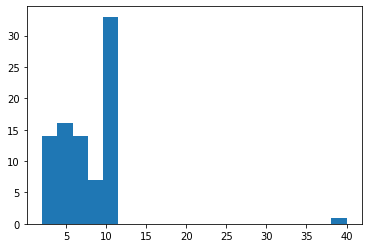

In [25]:
u_values = pd.Series({c: caravan[c].nunique(dropna=True) for c in caravan})

plt.hist(u_values, bins=20)

In [17]:


u_values[u_values == 40]

MOSTYPE    40
dtype: int64

In [32]:
obj_model, best_tree, t_exec, test_mod, mean_scores, rank_model = model(caravan)

/home/carlos/.pyenv/versions/3.7.4/envs/DPA/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


In [34]:
best_tree

'DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, random_state=1111)'